In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [2]:
#!apt-get update
#!apt-get install -y libsndfile1

In [3]:
import pandas as pd
import numpy as np

import os
import sys

import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

Пути к датасетам

In [4]:
Ravdess = "/content/gdrive/My Drive/ml/datasets/ravdess-emotional-speech-audio/audio_speech_actors_01-24/"
Crema = "/content/gdrive/My Drive/ml/datasets/cremad/AudioWAV/"
Tess = "/content/gdrive/My Drive/ml/datasets/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/"
Savee = "/content/gdrive/My Drive/ml/datasets/surrey-audiovisual-expressed-emotion-savee/ALL/"

In [5]:
ravdess_directory_list = os.listdir(Ravdess)

file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    # extract files for each actor
    actor = os.listdir(Ravdess + dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        file_emotion.append(int(part[2]))
        file_path.append(Ravdess + dir + '/' + file)
        
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head()

,Emotions,Path
0,neutral,/content/gdrive/My Drive/ml/datasets/ravdess-e...
1,calm,/content/gdrive/My Drive/ml/datasets/ravdess-e...
2,calm,/content/gdrive/My Drive/ml/datasets/ravdess-e...
3,neutral,/content/gdrive/My Drive/ml/datasets/ravdess-e...
4,calm,/content/gdrive/My Drive/ml/datasets/ravdess-e...


In [6]:
crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []

for file in crema_directory_list:
    file_path.append(Crema + file)
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')
        
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()

,Emotions,Path
0,happy,/content/gdrive/My Drive/ml/datasets/cremad/Au...
1,happy,/content/gdrive/My Drive/ml/datasets/cremad/Au...
2,neutral,/content/gdrive/My Drive/ml/datasets/cremad/Au...
3,disgust,/content/gdrive/My Drive/ml/datasets/cremad/Au...
4,fear,/content/gdrive/My Drive/ml/datasets/cremad/Au...


In [7]:
tess_directory_list = os.listdir(Tess)

file_emotion = []
file_path = []

for dir in tess_directory_list:
    directories = os.listdir(Tess + dir)
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part=='ps':
            file_emotion.append('surprise')
        else:
            file_emotion.append(part)
        file_path.append(Tess + dir + '/' + file)
        
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

path_df = pd.DataFrame(file_path, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)
Tess_df.head()

,Emotions,Path
0,disgust,/content/gdrive/My Drive/ml/datasets/toronto-e...
1,disgust,/content/gdrive/My Drive/ml/datasets/toronto-e...
2,disgust,/content/gdrive/My Drive/ml/datasets/toronto-e...
3,disgust,/content/gdrive/My Drive/ml/datasets/toronto-e...
4,disgust,/content/gdrive/My Drive/ml/datasets/toronto-e...


In [8]:
savee_directory_list = os.listdir(Savee)

file_emotion = []
file_path = []

for file in savee_directory_list:
    file_path.append(Savee + file)
    part = file.split('_')[1]
    ele = part[:-6]
    if ele=='a':
        file_emotion.append('angry')
    elif ele=='d':
        file_emotion.append('disgust')
    elif ele=='f':
        file_emotion.append('fear')
    elif ele=='h':
        file_emotion.append('happy')
    elif ele=='n':
        file_emotion.append('neutral')
    elif ele=='sa':
        file_emotion.append('sad')
    else:
        file_emotion.append('surprise')
        
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

path_df = pd.DataFrame(file_path, columns=['Path'])
Savee_df = pd.concat([emotion_df, path_df], axis=1)
Savee_df.head()

,Emotions,Path
0,angry,/content/gdrive/My Drive/ml/datasets/surrey-au...
1,angry,/content/gdrive/My Drive/ml/datasets/surrey-au...
2,angry,/content/gdrive/My Drive/ml/datasets/surrey-au...
3,angry,/content/gdrive/My Drive/ml/datasets/surrey-au...
4,angry,/content/gdrive/My Drive/ml/datasets/surrey-au...


In [9]:
data_path = pd.concat([Ravdess_df, Crema_df, Tess_df, Savee_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path.head()

,Emotions,Path
0,neutral,/content/gdrive/My Drive/ml/datasets/ravdess-e...
1,calm,/content/gdrive/My Drive/ml/datasets/ravdess-e...
2,calm,/content/gdrive/My Drive/ml/datasets/ravdess-e...
3,neutral,/content/gdrive/My Drive/ml/datasets/ravdess-e...
4,calm,/content/gdrive/My Drive/ml/datasets/ravdess-e...


### Визуализация данных

In [10]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

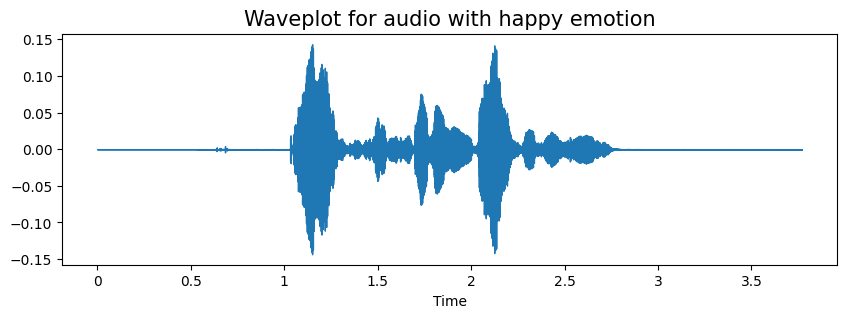

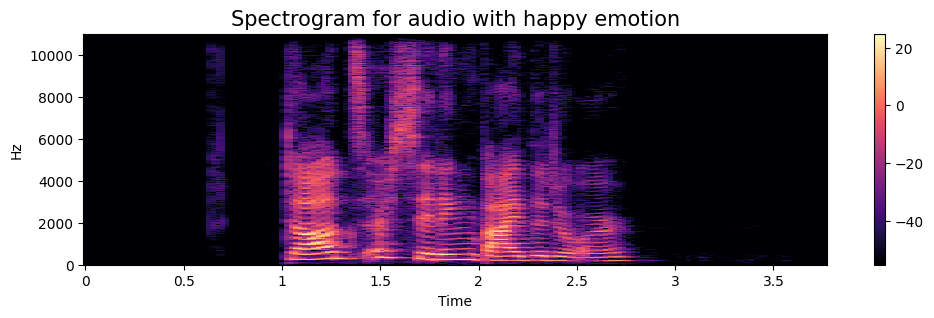

In [11]:
emotion='happy'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

In [12]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)

path = np.array(data_path.Path)[1]
data, sample_rate = librosa.load(path)

In [13]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

def get_features(path):
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    # with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically
    
    # with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically
    
    return result

In [14]:
X, Y = [], []
for path, emotion in zip(data_path.Path, data_path.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        Y.append(emotion)

/usr/local/lib/python3.9/dist-packages/librosa/core/pitch.py:102: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


In [15]:
len(X), len(Y), data_path.Path.shape

(36486, 36486, (12162,))

In [16]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,labels
0,0.256113,0.621621,0.580278,0.598515,0.628296,0.598015,0.597272,0.650352,0.698636,0.681863,...,0.000018,0.000016,0.000013,0.000012,0.000007,0.000008,0.000008,5.207213e-06,5.802853e-07,neutral
1,0.338189,0.708306,0.712949,0.722966,0.786003,0.764564,0.725650,0.687721,0.733835,0.743628,...,0.000310,0.000320,0.000309,0.000317,0.000302,0.000312,0.000309,3.101130e-04,3.145706e-04,neutral
2,0.172479,0.601313,0.585857,0.561815,0.547540,0.603391,0.537969,0.550347,0.572765,0.655308,...,0.000006,0.000004,0.000004,0.000003,0.000004,0.000002,0.000001,8.300282e-07,8.137897e-08,neutral
3,0.159315,0.550143,0.518438,0.473750,0.437024,0.433626,0.517483,0.531313,0.571939,0.542739,...,0.000160,0.000153,0.000087,0.000089,0.000386,0.000245,0.000200,3.709533e-04,2.675799e-05,calm
4,0.255778,0.623416,0.607900,0.571803,0.552430,0.568346,0.606570,0.579509,0.621128,0.605734,...,0.000187,0.000180,0.000117,0.000121,0.000409,0.000269,0.000228,3.961420e-04,5.394399e-05,calm


## Подготовка данных

In [17]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [18]:
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [19]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((27364, 162), (27364, 8), (9122, 162), (9122, 8))

##Нормализация

In [20]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((27364, 162), (27364, 8), (9122, 162), (9122, 8))

In [21]:
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((27364, 162, 1), (27364, 8), (9122, 162, 1), (9122, 8))

## Моделирование

In [22]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=8, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 162, 256)          1536      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 81, 256)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 81, 256)           327936    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 41, 256)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 41, 128)           163968    
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 21, 128)          0

In [23]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/50
428/428 [==============================] - 230s 533ms/step - loss: 1.6954 - accuracy: 0.3138 - val_loss: 1.4461 - val_accuracy: 0.4362 - lr: 0.0010
Epoch 2/50
428/428 [==============================] - 224s 524ms/step - loss: 1.4402 - accuracy: 0.4240 - val_loss: 1.3073 - val_accuracy: 0.4730 - lr: 0.0010
Epoch 3/50
428/428 [==============================] - 234s 547ms/step - loss: 1.3450 - accuracy: 0.4616 - val_loss: 1.2605 - val_accuracy: 0.5001 - lr: 0.0010
Epoch 4/50
428/428 [==============================] - 236s 552ms/step - loss: 1.2932 - accuracy: 0.4782 - val_loss: 1.1936 - val_accuracy: 0.5175 - lr: 0.0010
Epoch 5/50
428/428 [==============================] - 232s 543ms/step - loss: 1.2506 - accuracy: 0.5026 - val_loss: 1.1663 - val_accuracy: 0.5380 - lr: 0.0010
Epoch 6/50
428/428 [==============================] - 237s 553ms/step - loss: 1.2219 - accuracy: 0.5130 - val_loss: 1.1820 - val_accuracy: 0.5242 - lr: 0.0010
Epoch 7/50
428/428 [==========================

286/286 [==============================] - 17s 59ms/step - loss: 1.1579 - accuracy: 0.6264
Точность модели на тестовой выборке:  62.63977289199829 %


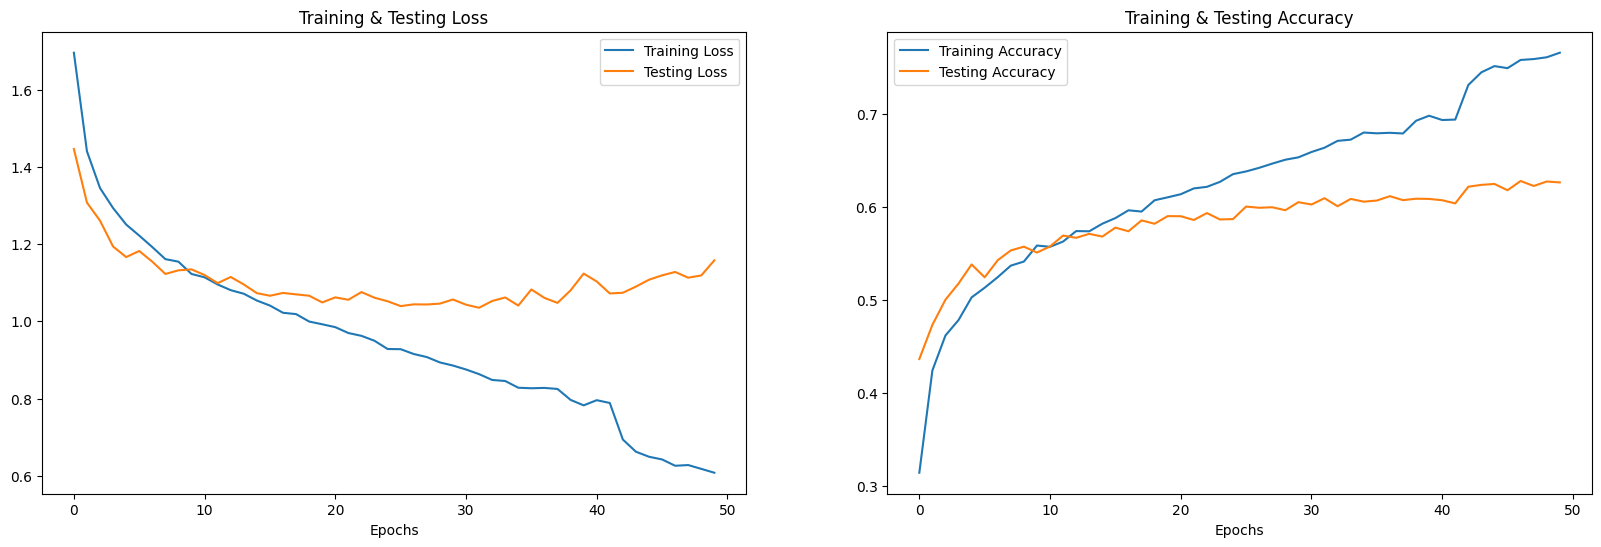

In [24]:
print("Точность модели на тестовой выборке: " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

## Прогнозирование на тестовой выборке

In [25]:
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

286/286 [==============================] - 17s 58ms/step


In [26]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

,Predicted Labels,Actual Labels
0,neutral,neutral
1,disgust,disgust
2,disgust,disgust
3,sad,sad
4,happy,happy
5,neutral,neutral
6,calm,calm
7,happy,happy
8,sad,sad
9,sad,sad


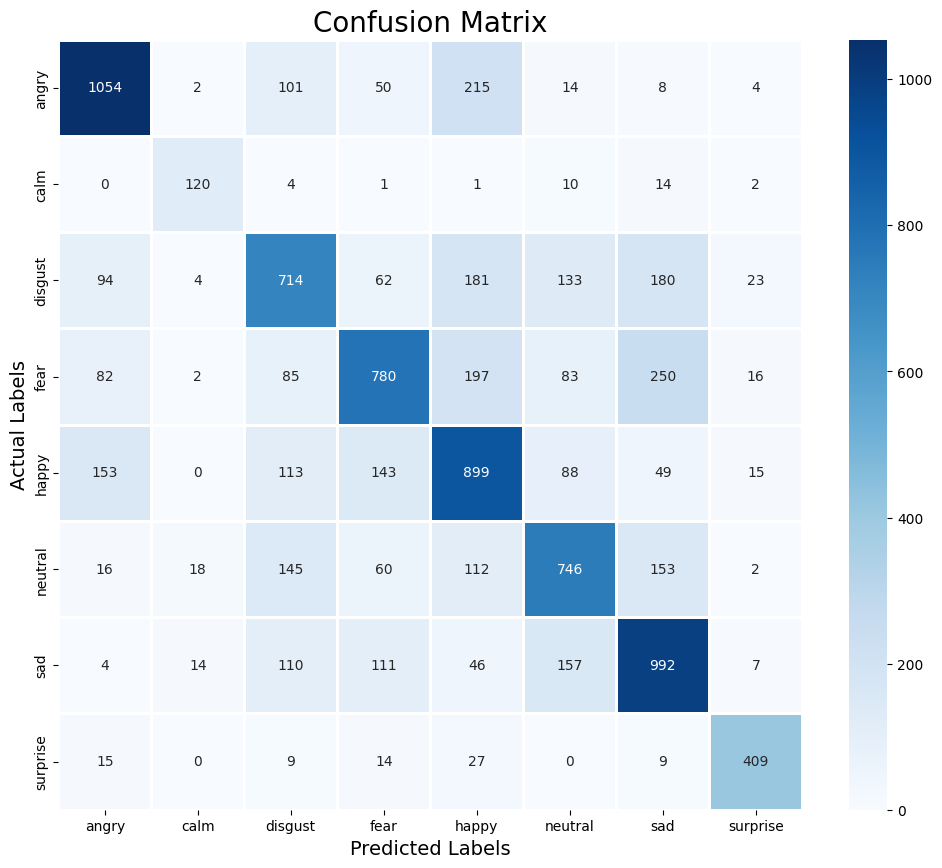

In [27]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [28]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.74      0.73      0.74      1448
        calm       0.75      0.79      0.77       152
     disgust       0.56      0.51      0.53      1391
        fear       0.64      0.52      0.57      1495
       happy       0.54      0.62      0.57      1460
     neutral       0.61      0.60      0.60      1252
         sad       0.60      0.69      0.64      1441
    surprise       0.86      0.85      0.85       483

    accuracy                           0.63      9122
   macro avg       0.66      0.66      0.66      9122
weighted avg       0.63      0.63      0.63      9122

